## Visualization

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(glue); library(lubridate)
    library(scales);library(reshape2); library(RColorBrewer);
})

### Editors

In [2]:
file <- "metrics/metrics.tsv"
contributor <- read.csv(file,sep = '\t')
contributor$month <- as.Date(contributor$month, format = "%Y-%m-%d")

In [3]:
tail(contributor)

,month,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile.heavy_wiki_active_editors,mobile.heavy_wiki_edits,mobile.heavy_wiki_new_editor_retention,⋯,net_new_content_pages,new_active_editors,new_editor_retention,non_anonymous_edits,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
249,2021-08-01,90312,2100177,25249,3594274,NA,2735392,5606,1322700,0.05882353,⋯,2331908,16299,0.06036647,45811721,5587077,74013,0.05031794,47913055,1311357,19905473
250,2021-09-01,88925,2052391,24011,3010823,NA,2498736,5164,997518,0.05548153,⋯,1684130,17042,0.06277591,37448564,6045787,71883,0.05483871,39502236,899197,15241328
251,2021-10-01,90041,2123708,23752,3271487,NA,2484138,5157,908283,0.05910219,⋯,2414980,17110,0.07290283,38745013,5959837,72931,0.05406598,40870218,1494555,14084019
252,2021-11-01,89995,2018200,23066,3303526,NA,2550849,5107,973932,0.05605111,⋯,1460354,16586,0.08079649,37416732,5973130,73409,0.05421922,39436215,586487,16358067
253,2021-12-01,89356,1995954,23172,3312507,NA,2672058,5315,1060115,0.04824919,⋯,1653680,16041,0.07285988,39301991,8267140,73315,0.05303383,41299016,746046,16768078
254,2022-01-01,94400,2196791,24440,4380346,NA,2692378,5588,2068915,0.04978723,⋯,1670762,17748,0.06247159,44069031,11540342,76652,0.05435584,46267521,781837,17365714


In [4]:
editors_fy <- contributor %>% 
     select(month,active_editors,new_active_editors,returning_active_editors) %>%
     filter(month >= '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2019-07-01' & month < '2020-07-01', 'FY 2019/20', ifelse(month <'2019-07-01','FY 2019/20',ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

editors_fy$MonthN = factor(editors_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

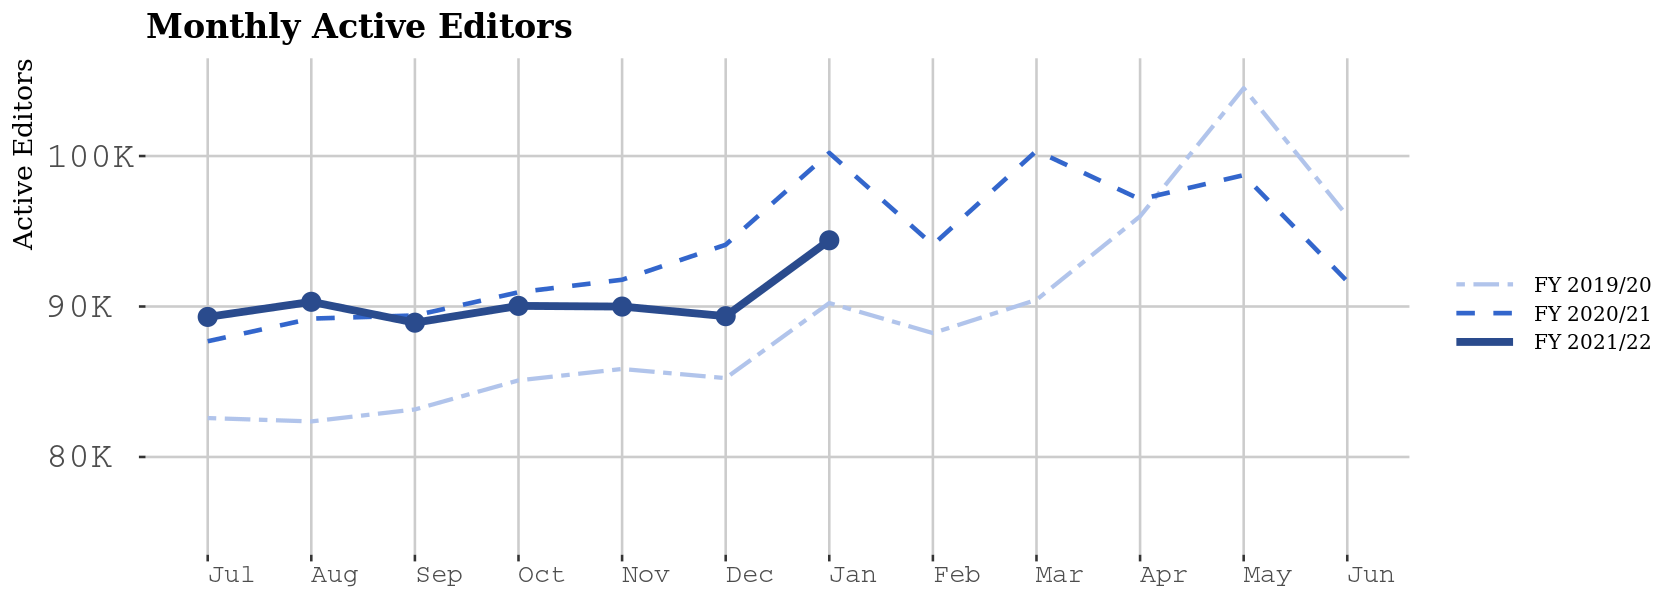

In [5]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- 
    ggplot(editors_fy,aes(x = MonthN,y = active_editors, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=editors_fy[(editors_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=active_editors, group=fiscal_year, color = fiscal_year),size = 5,color ="#2a4b8d")+
    scale_size_manual(values = c(1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2019/20" = "#b1c4eb", "FY 2020/21" = "#3366cc","FY 2021/22" = "#2a4b8d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = editors_fy$MonthN, labels = editors_fy$Month) +
    scale_y_continuous("Active Editors", labels = polloi::compress,limits = c(75E3, 105E3)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 16,family="Courier"),
           axis.text.y=element_text( hjust = 0,size = 22,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Active Editors") 

p1


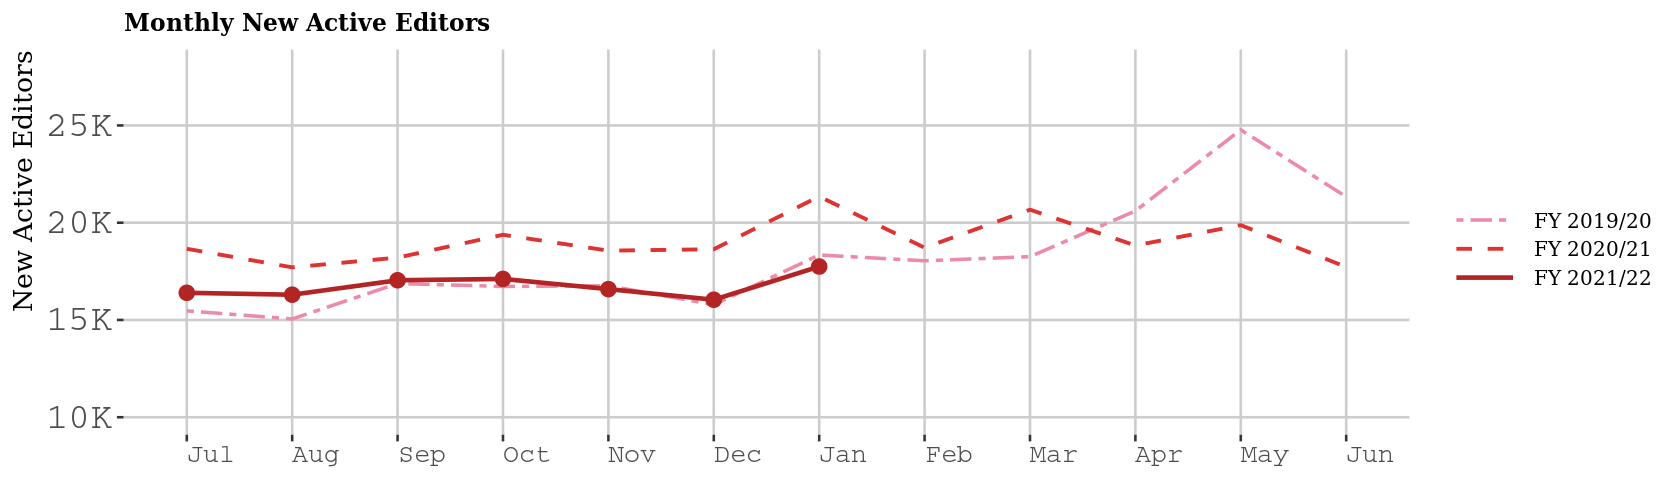

In [6]:
options(repr.plot.width = 14, repr.plot.height = 4)

p2 <- ggplot(editors_fy,
             aes(x = MonthN,y = new_active_editors, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)
            )+
    geom_line() +
    geom_point(data=editors_fy[(editors_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=new_active_editors, group=fiscal_year, color = fiscal_year),size = 4,color='#b32424')+

    scale_size_manual(values = c(1,1.1,1.3,2)) +
    scale_color_manual(values = c("FY 2019/20" = "#ec8ba7", "FY 2020/21" = "#dd3333","FY 2021/22" = "#b32424")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete("Month",
                      breaks = editors_fy$MonthN, 
                     labels = editors_fy$Month) +
    scale_y_continuous("New Active Editors",labels = polloi::compress,limits = c(10E3, 28E3)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text( hjust = 0,size = 16,family="Courier"),
           axis.text.y=element_text( hjust = 0,size = 22,family="Courier"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 14,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly New Active Editors") 

p2

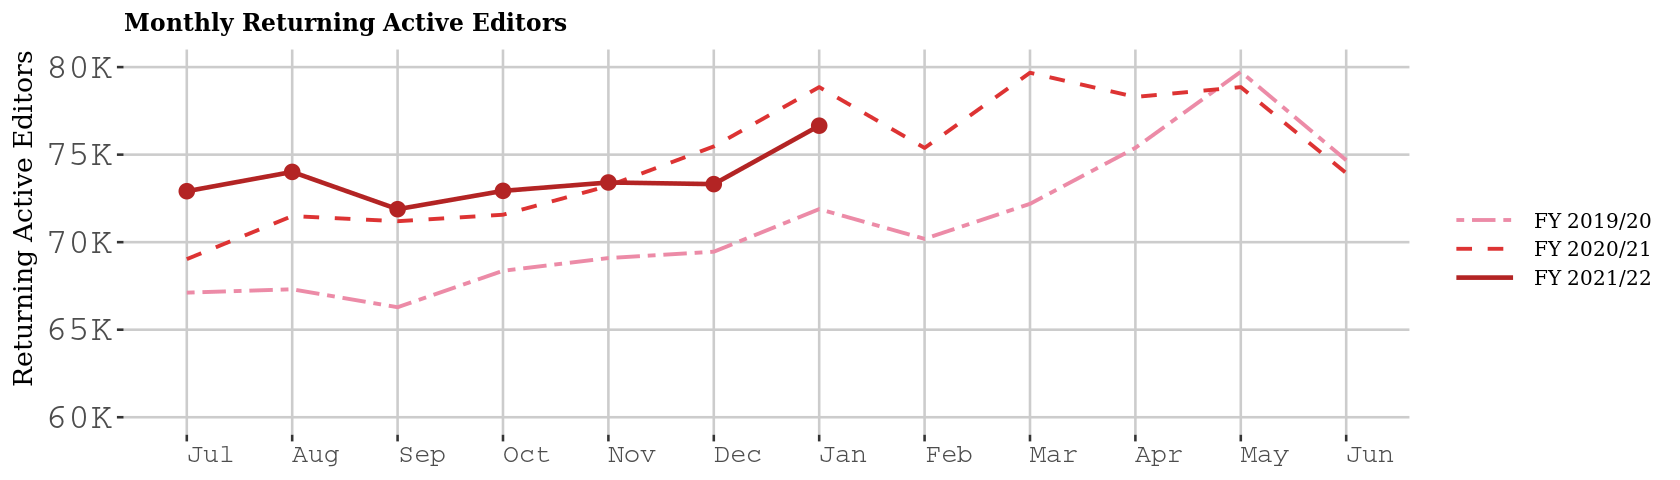

In [7]:
options(repr.plot.width = 14, repr.plot.height = 4)

p3 <- ggplot(editors_fy,aes(x = MonthN,y = returning_active_editors, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=editors_fy[(editors_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=returning_active_editors, group=fiscal_year, color = fiscal_year),size = 4,color='#b32424')+
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +
    scale_color_manual(values = c("FY 2019/20" = "#ec8ba7", "FY 2020/21" = "#dd3333","FY 2021/22" = "#b32424")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete("Month",breaks = editors_fy$MonthN, labels = editors_fy$Month) +
    scale_y_continuous("Returning Active Editors", labels = polloi::compress,limits = c(60E3,80E3)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
     theme(axis.title.x=element_blank(),
           axis.text.x=element_text( hjust = 0,size = 16,family="Courier"),
           axis.text.y=element_text( hjust = 0,size = 22,family="Courier"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 14,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
           legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Returning Active Editors")

p3

### Net new Content

In [8]:
content_fy <- contributor %>% 
     select(month,net_new_content_pages,net_new_Commons_content_pages,net_new_Wikidata_entities,net_new_Wikipedia_articles) %>%
     mutate(without_wikidata = net_new_content_pages - net_new_Wikidata_entities ) %>%
     #filter(month >= '2018-07-01') %>%
     filter(month >= '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2019-07-01' & month < '2020-07-01', 'FY 2019/20', ifelse(month <'2019-07-01','FY 2018/19',ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

content_fy$MonthN = factor(content_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

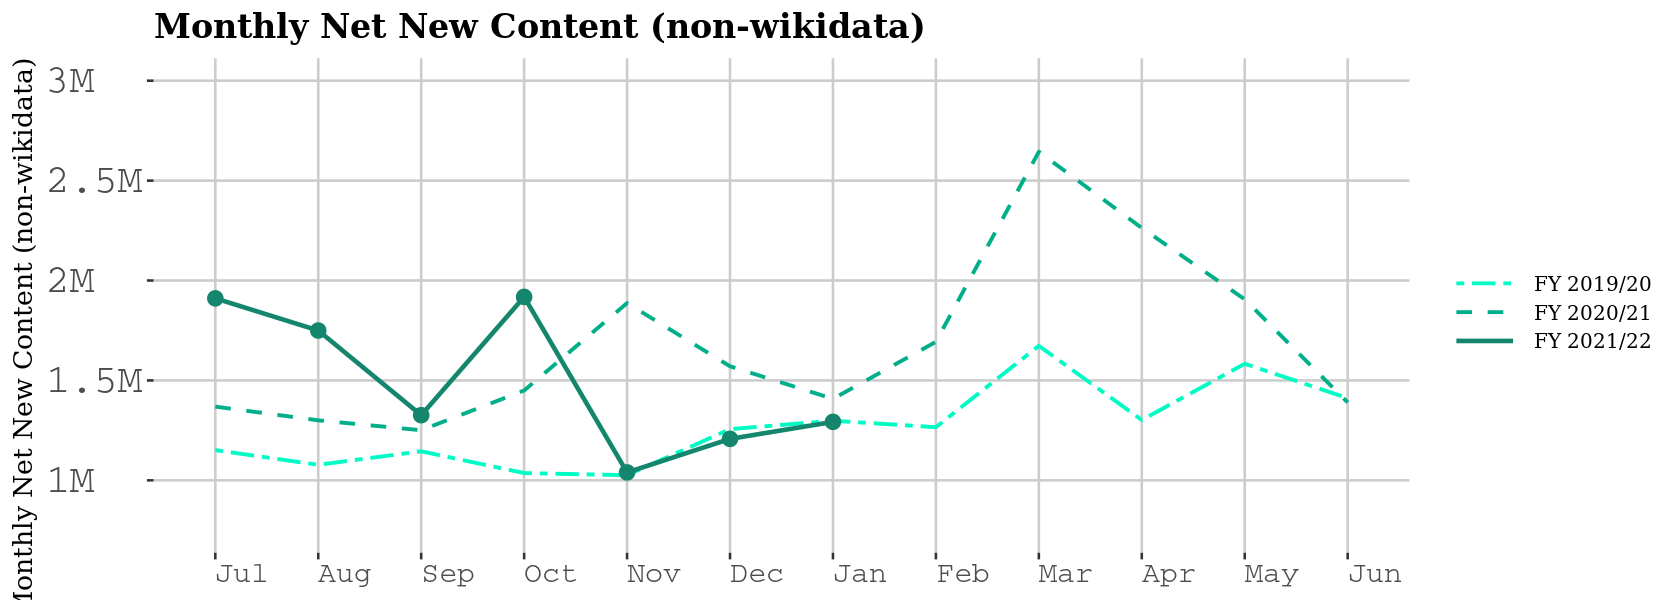

In [9]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <-
    ggplot(content_fy,aes(x = MonthN,y = without_wikidata, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=content_fy[(content_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=without_wikidata, group=fiscal_year, color = fiscal_year),size = 4,color='#14866d')+
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +

    scale_color_manual(values = c("FY 2019/20" = "#00fcc5", "FY 2020/21" = "#00af89","FY 2021/22" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net New Content (non-wikidata)", labels = polloi::compress,limits = c(75E4, 300E4)) +

    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net New Content (non-wikidata)") 

p1

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



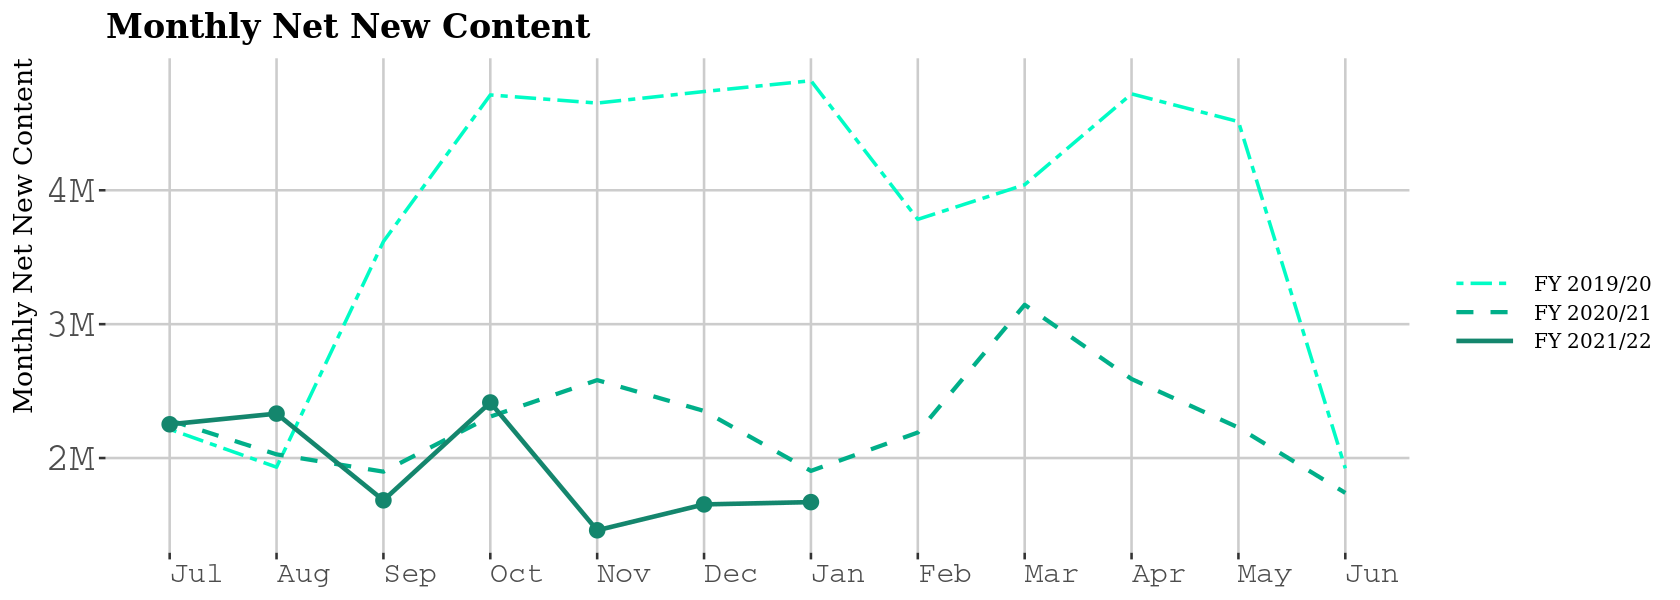

In [10]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- 
    ggplot(content_fy,aes(x = MonthN,y = net_new_content_pages, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=content_fy[(content_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=net_new_content_pages, group=fiscal_year, color = fiscal_year),size = 4,color='#14866d')+
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +

    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2019/20" = "#00fcc5", "FY 2020/21" = "#00af89","FY 2021/22" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net New Content", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net New Content") 

p1

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



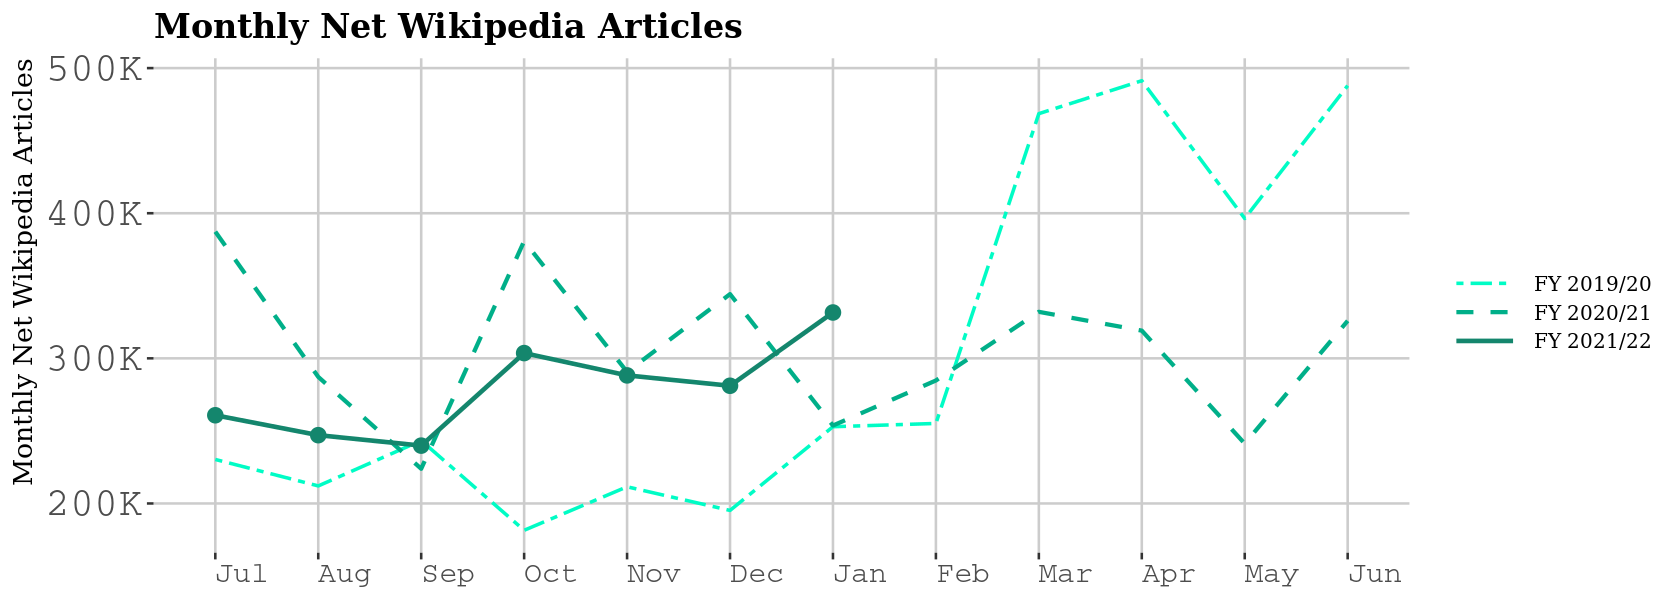

In [11]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- 
    ggplot(content_fy,aes(x = MonthN,y = net_new_Wikipedia_articles, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=content_fy[(content_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=net_new_Wikipedia_articles, group=fiscal_year, color = fiscal_year),size = 4,color='#14866d')+
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2019/20" = "#00fcc5", "FY 2020/21" = "#00af89","FY 2021/22" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net Wikipedia Articles", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net Wikipedia Articles") 

p1


Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



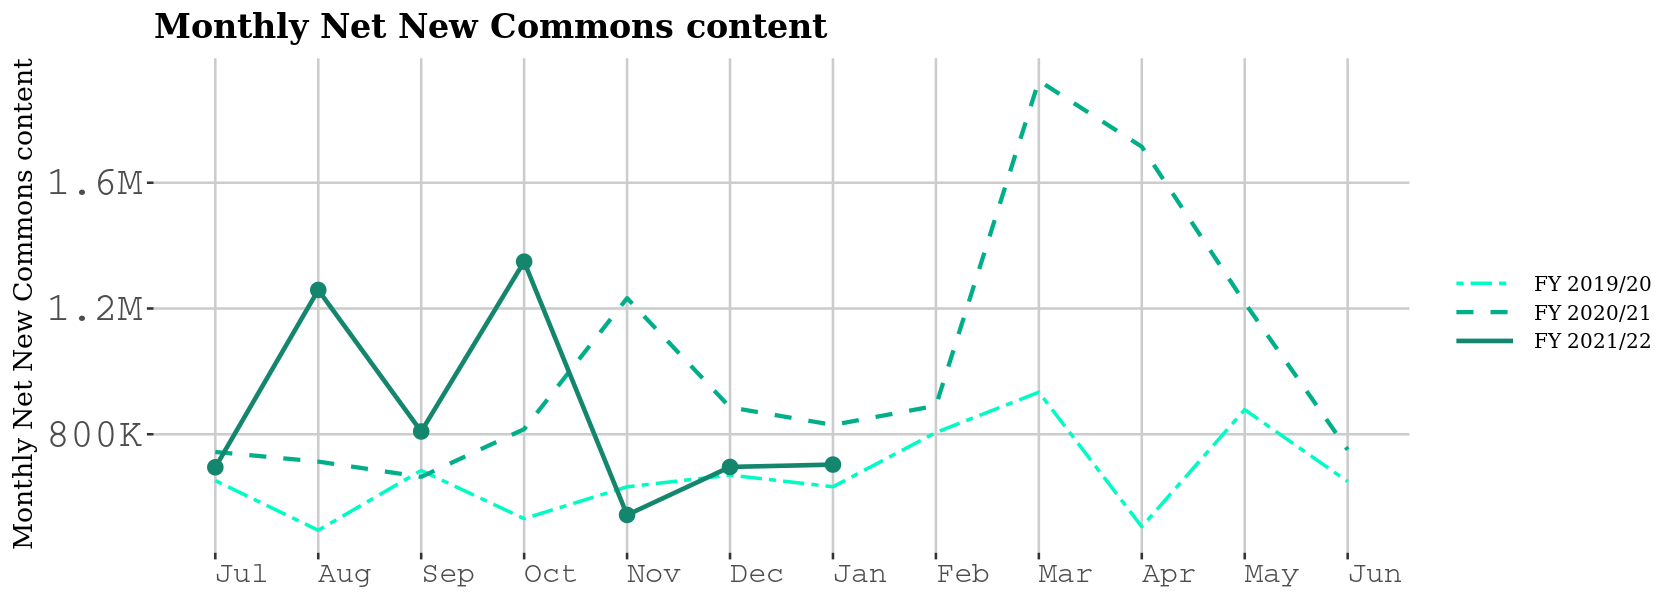

In [12]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- 

    ggplot(content_fy,aes(x = MonthN,y = net_new_Commons_content_pages, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=content_fy[(content_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=net_new_Commons_content_pages, group=fiscal_year, color = fiscal_year),size = 4,color='#14866d')+
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +
    scale_size_manual(values = c(1,1.2,1.3,2.2)) +
    scale_color_manual(values = c("FY 2019/20" = "#00fcc5", "FY 2020/21" = "#00af89","FY 2021/22" = "#14866d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = content_fy$MonthN, labels = content_fy$Month) +
    scale_y_continuous("Monthly Net New Commons content", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Net New Commons content") 

p1


In [13]:
retention_fy <- contributor %>% 
     select(month,new_editor_retention) %>%
      filter(month >= '2019-07-01') %>%
      mutate(fiscal_year = ifelse(month >= '2019-07-01' & month < '2020-07-01', 'FY 2019/20', ifelse(month <'2019-07-01','FY 2018/17',ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

retention_fy$MonthN = factor(retention_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))



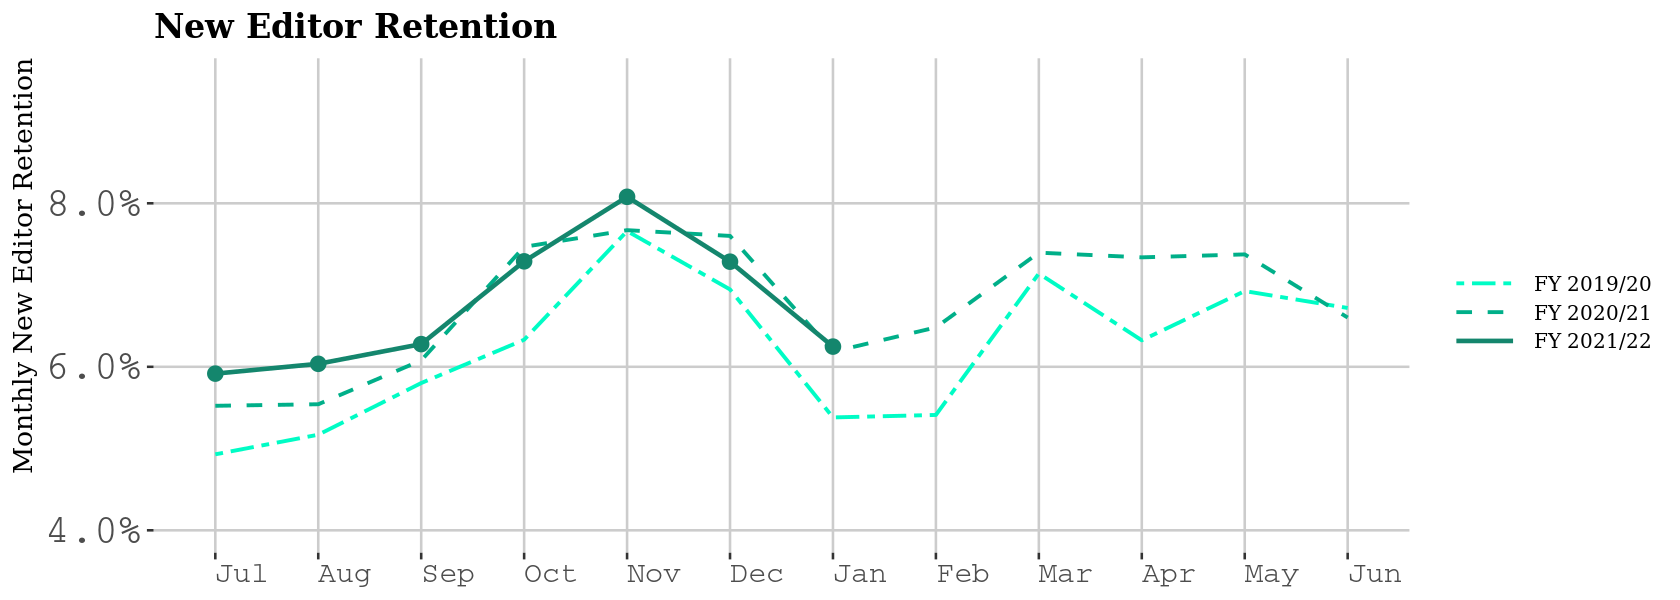

In [14]:

options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(retention_fy,aes(x = MonthN,y = new_editor_retention, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year))+
    geom_line() +
    geom_point(data=retention_fy[(retention_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=new_editor_retention, group=fiscal_year, color = fiscal_year),size = 4,color='#14866d')+
    scale_size_manual(values = c(1.1,1.1,1.3,2)) +
    scale_color_manual(values = c("FY 2019/20" = "#00fcc5", "FY 2020/21" = "#00af89","FY 2021/22" = "#14866d")) +

    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = retention_fy$MonthN, labels = retention_fy$Month) +
    scale_y_continuous("Monthly New Editor Retention", labels = scales::percent,limits = c(0.04, 0.095)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "New Editor Retention") 

p1

## Anoy edits testing

In [15]:
anoy_fy <- contributor %>% 
     select(month,anonymous_edits,non_anonymous_edits) %>%
     filter(month >= '2020-07-01') %>%
     melt(id.var = "month", measure.vars = c("anonymous_edits", "non_anonymous_edits") ) %>%
     mutate(fiscal_year = ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

anoy_fy$MonthN = factor(anoy_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))


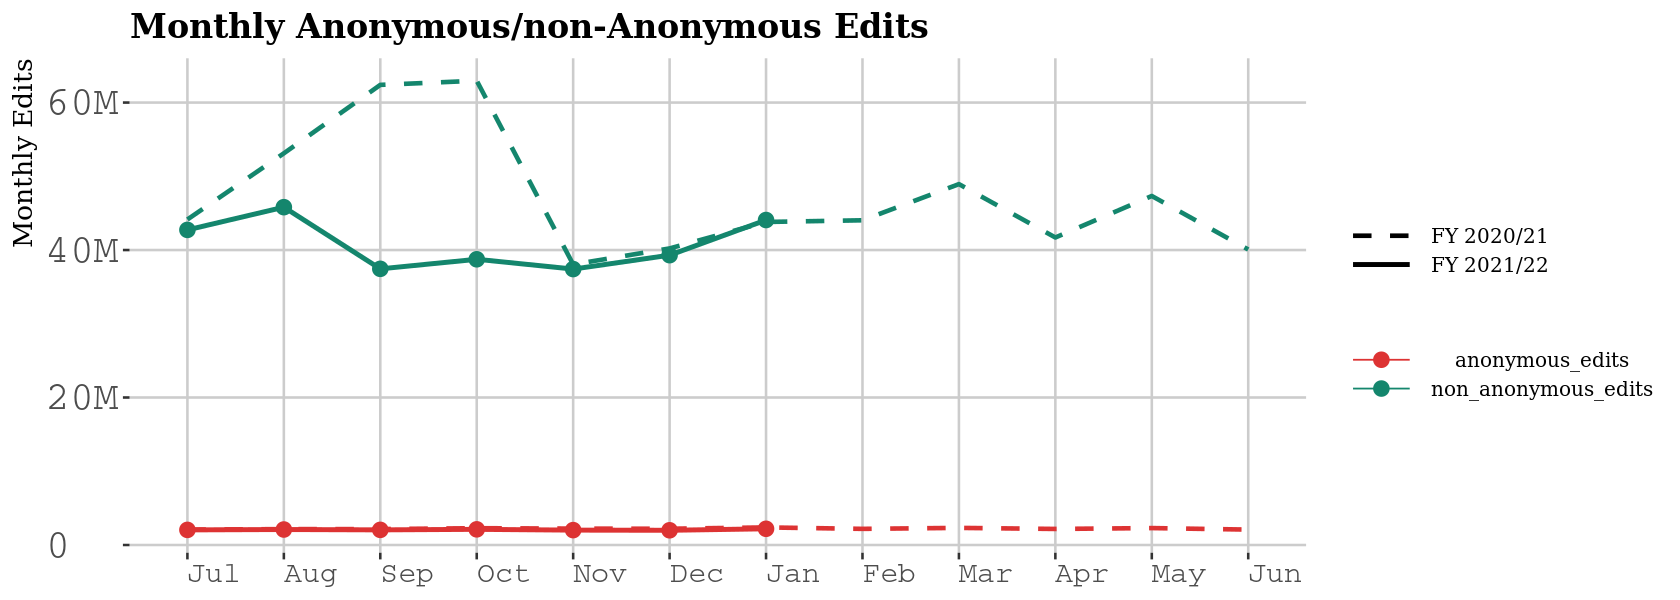

In [16]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(anoy_fy,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = value, group=interaction(fiscal_year,variable), color = variable,size=fiscal_year,linetype = fiscal_year)) +
    scale_size_manual(values = c(1.3,1.4)) +
    geom_point(data=anoy_fy[(anoy_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=value, group=interaction(fiscal_year,variable), color = variable),size = 4)+
    scale_color_manual(values = c( "anonymous_edits" = "#dd3333","non_anonymous_edits" = "#14866d")) +
    scale_linetype_manual(values=c( "dashed","solid")) +
    scale_x_discrete(breaks =anoy_fy$MonthN, labels = anoy_fy$Month) +
    scale_y_continuous("Monthly Edits", labels = polloi::compress) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Anonymous/non-Anonymous Edits") 

p1

In [17]:
anoy_fy_t <- anoy_fy %>% filter(variable=='anonymous_edits')
anoy_fy_f <- anoy_fy %>% filter(variable=='non_anonymous_edits')

Warning message:
“Removed 7 rows containing missing values (geom_point).”


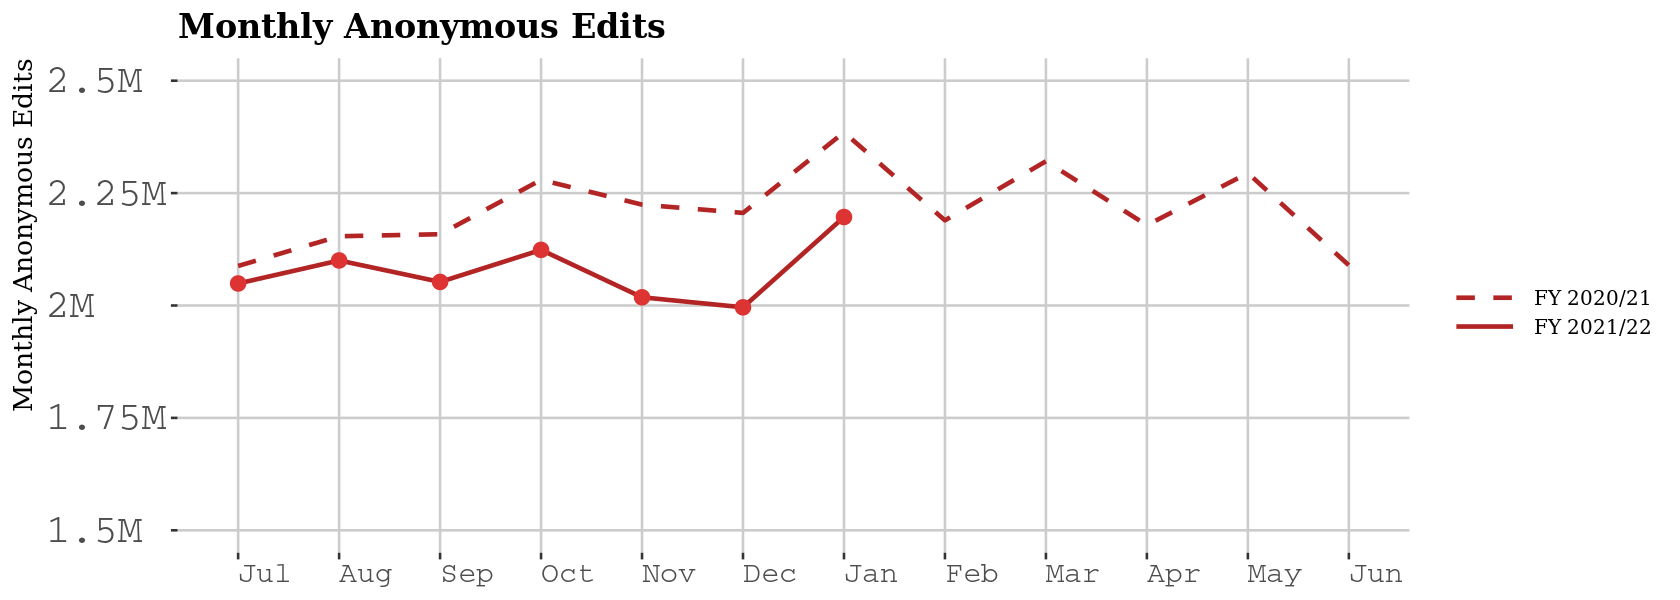

In [18]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(anoy_fy_t,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = value, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    geom_point(data=anoy_fy[(anoy_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=value, group=interaction(fiscal_year,variable)),size = 4,colour="#dd3333")+
    scale_size_manual(values = c(1.3,1.3)) +
    scale_color_manual(values = c("FY 2020/21" = "#b32424","FY 2021/22" = "#b32424")) +
    scale_linetype_manual(values=c("dashed","solid","solid")) +
    scale_x_discrete(breaks = anoy_fy_t$MonthN, labels = anoy_fy_t$Month) +
    scale_y_continuous("Monthly Anonymous Edits", labels = polloi::compress,limits = c(1.5E6, 2.5E6)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Anonymous Edits") 

p1

Warning message:
“Removed 7 rows containing missing values (geom_point).”


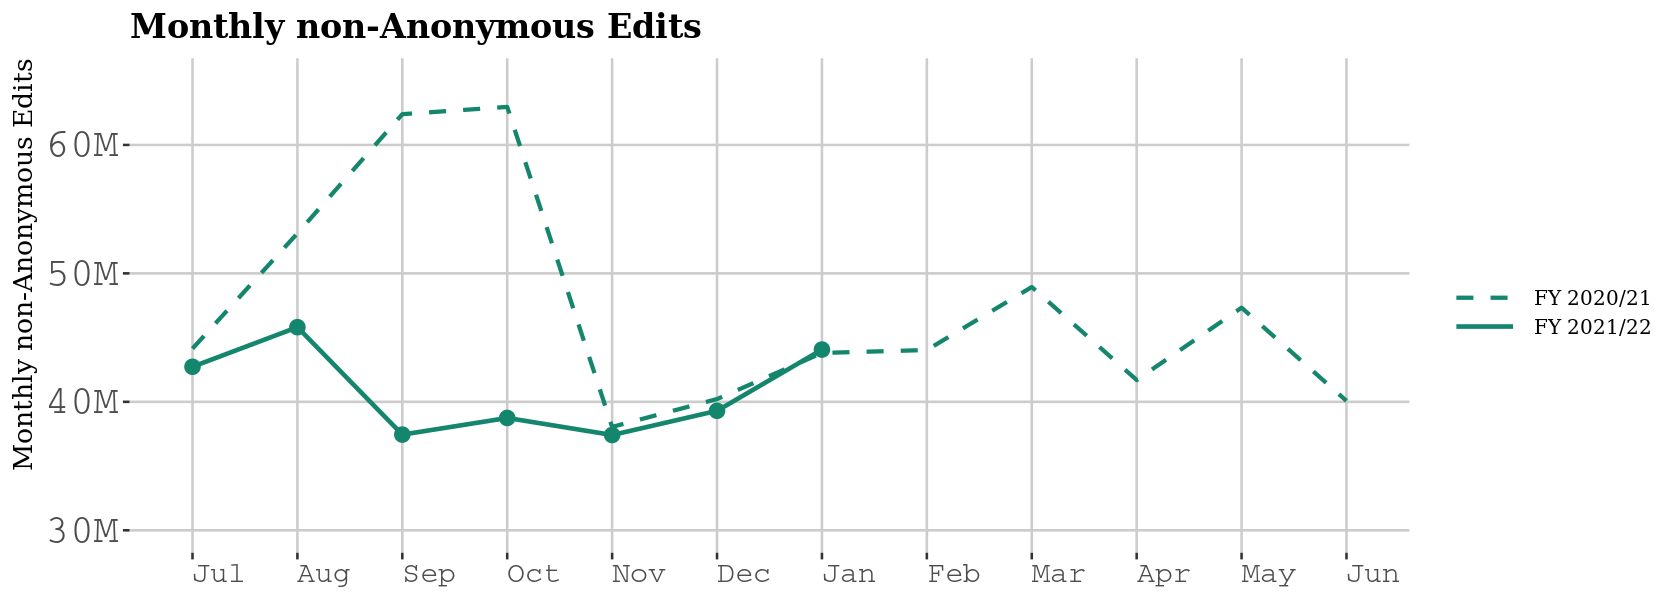

In [19]:
options(repr.plot.width = 14, repr.plot.height = 5)

p1 <- ggplot(anoy_fy_f,aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = value, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    geom_point(data=anoy_fy[(anoy_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=value, group=interaction(fiscal_year,variable)),size = 4,colour="#14866d")+
    scale_size_manual(values = c(1.2,1.3)) +
    scale_color_manual(values = c("FY 2020/21" = "#14866d","FY 2021/22" = "#14866d")) +
    scale_linetype_manual(values=c("dashed","solid")) +
    scale_x_discrete(breaks = anoy_fy_f$MonthN, labels = anoy_fy_f$Month) +
    scale_y_continuous("Monthly non-Anonymous Edits", labels = polloi::compress,limits = c(3E7, 6.5E7)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.text.x=element_text( hjust = 0,size = 18,family="Courier"),
          axis.text.y=element_text( hjust = 0,size = 24,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=16,hjust = 1),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 12),
          legend.key.width=unit(1.5,"cm"),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly non-Anonymous Edits") 

p1